# Compare inflow profiles

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

from matplotlib.lines import Line2D

In [2]:
def timeaverage(t, dat, t1, t2):
    Ndim   = len(np.shape(dat))
    tfiltered   = t[(t>=t1)&(t<=t2)]
    if Ndim==1:
        datfiltered = dat[(t>=t1)&(t<=t2)]
    else:
        datfiltered = dat[(t>=t1)&(t<=t2),:]
        Nvars  = len(dat[0,:])
    tstart = tfiltered[0]
    tend   = tfiltered[-1]
    avgdat = 0.0 if Ndim==1 else np.zeros(Nvars)
    for i in range(len(tfiltered)-1):
        dt     = tfiltered[i+1] - tfiltered[i]
        if Ndim==1:
            avgdat = avgdat + 0.5*dt*(datfiltered[i+1] + datfiltered[i])
        else:
            avgdat = avgdat + 0.5*dt*(datfiltered[i+1,:] + datfiltered[i,:])
    return avgdat/(tend-tstart)

In [3]:
# Put the list of all cases in here
cases = [
    # AMR-Wind data defs
    {'label':'AMRWIND',
     'datadir':'../AMR.5kmX5km_turbine1/post_processing/data',
     'prefix':'AMRWIND',
     'fname':'{prefix}_InflowProfiles_noturbine.dat',
     'fname_rotthrust':'{prefix}_turb_RotThrust.dat',
     'fname_pwr':'{prefix}_turb_GenPwr.dat',
     'linestyle':{'linestyle':'-', 'lw':2},
     'datacol':5,
    },
    
    # Nalu data defs
    {'label':'NALUWIND',
     'datadir':'../NALU.5kmX5km_turbine1/postprocessing/data',
     'prefix':'NALUWIND',
     'fname':'{prefix}_InflowProfiles_noturbine.dat',
     'fname_rotthrust':'{prefix}_turb_RotThrust.dat',
     'fname_pwr':'{prefix}_turb_GenPwr.dat',
     'linestyle':{'linestyle':'--', 'lw':2},
     'datacol':5,
    },

]

In [4]:
zhh=90

AMRWIND 6.264256091542275
NALUWIND 6.162847989182723


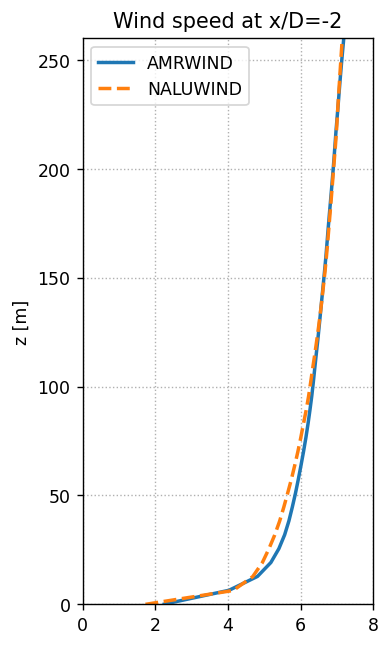

In [5]:
fig, ax = plt.subplots(1,1, figsize=(3,6), dpi=125)
for icase, case in enumerate(cases):
    label   = case['label']
    prefix  = case['prefix']
    datadir = case['datadir']
    col     = case['datacol']
    lstyle  = case['linestyle']
    if 'fname' in case:
        fname   = case['fname'] 
        dat=np.loadtxt(datadir+'/'+fname.format(prefix=prefix))
        z  = dat[:,0]
        uh = dat[:,col]
        ax.plot(uh, z,  label=label, **lstyle) # color=cycle[ix],
        
        Uhh  = np.interp(zhh, z, uh)
        cases[icase]['Uhh'] = Uhh
        print(label, Uhh)

ax.legend()
ax.set_xlim([0, 8])
ax.set_ylim([0, 260])
ax.set_ylabel('z [m]')
ax.set_title('Wind speed at x/D=-2')
ax.grid(ls=':')

In [6]:
import urllib.request
import io
#from cStringIO import StringIO
import ssl
from io import StringIO

#url='https://raw.githubusercontent.com/IEAWindTask37/IEA-15-240-RWT/master/performance/performance_ccblade.dat'
#url='https://raw.githubusercontent.com/IEAWindTask37/IEA-15-240-RWT/34f452dd428ef568145bfa5df48d12cbf2563911/performance/performance_ccblade.dat'
url='https://raw.githubusercontent.com/lawrenceccheung/AWAKEN_summit_setup/main/turbines/GE2.8-127/NREL-2.8-127.csv'

# This restores the same behavior as before.
context = ssl._create_unverified_context()
f = io.BytesIO(urllib.request.urlopen(url, context=context).read())
text_obj = f.read().decode('utf-8')
designcurve=pd.read_csv(StringIO(text_obj), dtype=str)
f.close()

# Show the headers
f = io.BytesIO(urllib.request.urlopen(url, context=context).read())
text_obj = f.read().decode('utf-8')
header=text_obj.partition('\n')[0]
print('File headers:')
for ix, x in enumerate(header.split('\t')): print("%i: %s"%(ix, x))
f.close()

File headers:
0: wind speed [m/s],aerodynamic power [kW],generator power [kW],rotor thrust [kN],rotor torque [kN-m],rotor speed [RPM],blade pitch [deg],tip-speed ratio [-],Cp [-],Ct [-]


In [7]:
# Extract rotor thrust
for icase, case in enumerate(cases):
    label   = case['label']
    prefix  = case['prefix']
    datadir = case['datadir']
    lstyle  = case['linestyle']
    if 'fname_rotthrust' in case:
        fname   = case['fname_rotthrust']
        dat=np.loadtxt(datadir+'/'+fname.format(prefix=prefix), skiprows=2)
        ax.plot(dat[:,0], dat[:,1],  label=prefix, **lstyle) # color=cycle[ix],
        thrust = timeaverage(dat[:,0], dat[:,1], 300, 900)
        print("%-10s %f"%(label, thrust))
        cases[icase]['rotthrust'] = thrust
    

AMRWIND    263.515302
NALUWIND   237.450677


AMRWIND 240.759771837571
NALUWIND 233.0473978790818


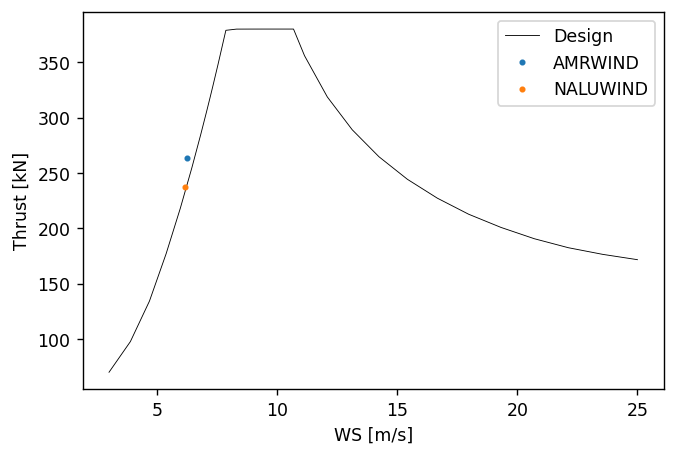

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=125)

designWS     = designcurve['wind speed [m/s]'].to_numpy(dtype=float)
designthrust = designcurve['rotor thrust [kN]'].to_numpy(dtype=float)

plt.plot(designWS, designthrust, 'k', lw=0.5, label='Design')
for case in cases:
    designpt = np.interp(case['Uhh'], designWS, designthrust)
    print(case['label'], designpt) 
    plt.plot(case['Uhh'], case['rotthrust'], '.', ms=5, label=case['label'])
    
plt.xlabel('WS [m/s]')
plt.ylabel('Thrust [kN]')
plt.legend()

In [9]:
for icase, case in enumerate(cases):
    label   = case['label']
    prefix  = case['prefix']
    datadir = case['datadir']
    lstyle  = case['linestyle']
    if 'fname_pwr' in case:
        fname   = case['fname_pwr'] #f'{prefix}_HH_VEL_PROFILE_x_{xD:06.2f}D.dat'
        dat=np.loadtxt(datadir+'/'+fname.format(prefix=prefix), skiprows=2)
        ax.plot(dat[:,0], dat[:,1],  label=prefix, **lstyle) # color=cycle[ix],
        power = timeaverage(dat[:,0], dat[:,1], 300, 900)
        print("%-10s %f"%(label, power))
        cases[icase]['power'] = power

AMRWIND    726.028977
NALUWIND   683.624962


AMRWIND 781.4659574606511
NALUWIND 743.9133393981681


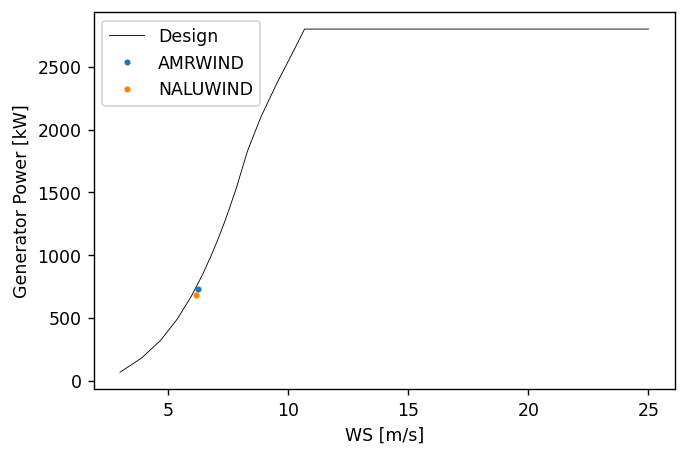

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=125)

designWS     = designcurve['wind speed [m/s]'].to_numpy(dtype=float)
designpwr    = designcurve['generator power [kW]'].to_numpy(dtype=float)

plt.plot(designWS, designpwr, 'k', lw=0.5, label='Design')
for case in cases:
    designpt = np.interp(case['Uhh'], designWS, designpwr)
    print(case['label'], designpt) 
    plt.plot(case['Uhh'], case['power'], '.', ms=5, label=case['label'])
    
plt.xlabel('WS [m/s]')
plt.ylabel('Generator Power [kW]')
plt.legend()